## 2.1 图像相关层

图像相关层主要包括卷积层（Conv）、池化层（Pool）等，这些层在实际使用中可分为一维(1D)、二维(2D)、三维（3D），池化方式又分为平均池化（AvgPool）、最大值池化（MaxPool）、自适应池化（AdaptiveAvgPool）等。    
而卷积层除了常用的前向卷积之外，还有逆卷积（TransposeConv）

In [6]:
import torch as t
from torch import nn
import numpy as np

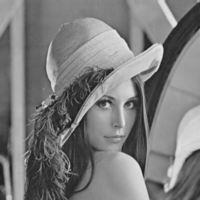

In [1]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage

to_tensor = ToTensor()
to_pil = ToPILImage()

lena = Image.open('./imgs/lena.png')
lena

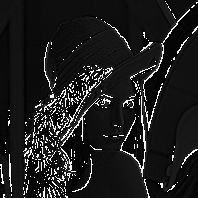

In [9]:
input = to_tensor(lena).unsqueeze(0)

# 锐化卷积核
kernel = t.ones(3, 3) / -9
kernel[1][1] = 1
conv = nn.Conv2d(1, 1, (3, 3,), 1, bias=False)
conv.weight.data = kernel.view(1, 1, 3, 3)

out = conv(input)
to_pil(out.data.squeeze(0))

池化层weight固定，没有可学习的参数

In [17]:
pool = nn.AvgPool2d(3, 3)
list(pool.parameters())

[]

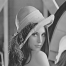

In [18]:
out = pool(input)
to_pil(out.data.squeeze(0))

除了卷积层和池化层，深度学习中还将常用到以下几个层：
- Linear：全连接层。
- BatchNorm：批规范化层，分为1D、2D和3D。除了标准的BatchNorm之外，还有在风格迁移中常用到的InstanceNorm层。
- Dropout：dropout层，用来防止过拟合，同样分为1D、2D和3D

In [23]:
input = t.randn(2, 3)
linear = nn.Linear(3, 4)
l = linear(input)
l

tensor([[ 0.0444, -0.0491,  0.0591,  0.4694],
        [-0.1402, -0.3979, -0.0316,  0.6278]], grad_fn=<AddmmBackward>)

In [24]:
# 4 channel, 初始化标准差=4， 均值=0
bn = nn.BatchNorm1d(4)
bn.weight.data = t.ones(4) * 4 
bn.bias.data = t.zeros(4)

print(bn.weight.data)
print(bn.bias.data)

tensor([4., 4., 4., 4.])
tensor([0., 0., 0., 0.])


In [25]:
bn_out = bn(l)

# 方差是标准差的平方，计算无偏方差分母会减1
# 使用unbiased=False 分母不减1
print(bn_out.mean())
print(bn_out.var(0, unbiased=False))

tensor(-8.9407e-08, grad_fn=<MeanBackward0>)
tensor([15.9812, 15.9947, 15.9226, 15.9745], grad_fn=<VarBackward1>)


In [26]:
dropout = nn.Dropout(0.5)
o = dropout(bn_out)
o

tensor([[ 0.0000,  7.9987,  7.9806, -7.9936],
        [-7.9953, -0.0000, -0.0000,  7.9936]], grad_fn=<MulBackward0>)

## 2.2 前馈传播网络     
这种将每一层的输出直接作为下一层的输入，这种网络称为前馈传播网络（feedforward neural network）。对于此类网络如果每次都写复杂的forward函数会有些麻烦，在此就有两种简化方式，ModuleList和Sequential。
- Sequential：是一个特殊的module，它包含几个子Module，前向传播时会将输入一层接一层的传递下去
- ModuleList：也是一个特殊的module，可以包含几个子module，可以像用list一样使用它，但不能直接把输入传给ModuleList

In [4]:
# Sequential的三种方式  
net1 = nn.Sequential()
net1.add_module('conv', nn.Conv2d(3, 3, 3))
net1.add_module('BatchNorm', nn.BatchNorm2d(3))
net1.add_module('activation', nn.ReLU())
net1

Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (BatchNorm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
)

In [6]:
net2 = nn.Sequential(
    nn.Conv2d(3, 3, 3),
    nn.BatchNorm2d(3),
    nn.ReLU()
)
net2

Sequential(
  (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [8]:
from collections import OrderedDict

net3 = nn.Sequential(OrderedDict([
    ('conv3', nn.Conv2d(3, 3, 3)),
    ('BatchNorm3', nn.BatchNorm2d(3)),
    ('activation3', nn.ReLU())
])
)
net3

Sequential(
  (conv3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (BatchNorm3): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation3): ReLU()
)

In [9]:
# 可根据名字或序号取出子module
net1.conv, net2[0], net3.conv3

(Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)))

In [12]:
input = t.randn(1, 3, 4, 4)

out = net3.activation3(net1.BatchNorm(net1.conv(input)))
out

tensor([[[[0.0546, 0.0000],
          [0.0000, 0.4607]],

         [[0.4028, 0.0000],
          [0.0000, 0.8724]],

         [[0.0000, 0.0000],
          [0.3714, 0.2536]]]], grad_fn=<ReluBackward0>)

In [14]:
# modulelist
modulelist = nn.ModuleList([nn.Linear(3, 4), nn.ReLU(), nn.Linear(4, 2)])
input = t.randn(1, 3)
for model in modulelist:
    input = model(input)
# 下面会报错,因为modellist没有实现forward方法
# output = modelist(input)

#### PS: List 和 ModuleList        
为何不直接使用Python中自带的list???    
`ModuleList`是`Module`的子类， 当在`Module`中使用它的时候，就能自动识别为`子module`

In [19]:
# 例子
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.list = [nn.Linear(3, 4), nn.ReLU()]
        self.modulelist = nn.ModuleList([nn.Conv2d(3, 3, 3), nn.ReLU()])
        
    def forward():
        pass
    
mymodule = MyModule()
mymodule

MyModule(
  (modulelist): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
)

In [20]:
for name,params in mymodule.named_parameters():
    print(name, params.shape)

modulelist.0.weight torch.Size([3, 3, 3, 3])
modulelist.0.bias torch.Size([3])


由上可见，ModuleList中的子module能够被主module所识别   


除ModuleList之外还有`ParameterList`，其是一个可以包含多个parameter的类list对象。  
在实际应用中，使用方式与ModuleList类似。如果在构造函数`__init__`中用到`list、tuple、dict`等对象时，一定要思考是否应该用ModuleList或ParameterList代替

## 2.3 激活函数   
PyTorch实现了常见的激活函数，其具体的接口信息可参见官方文档，这些激活函数可作为独立的layer使用。

In [23]:
# relu
relu = nn.ReLU(inplace=True)
input = t.randn(2, 3)
print(input)
 
out = relu(input) # 等价于 input.clamp(min=0) / 截断,<0的都为0
print(out)

tensor([[ 1.3448,  1.6002,  0.9388],
        [-0.5534, -0.3827,  0.1502]])
tensor([[1.3448, 1.6002, 0.9388],
        [0.0000, 0.0000, 0.1502]])


inplace参数，如果设为True，它会把输出直接覆盖到输入中，这样可以节省内存/显存。    

之所以可以覆盖是因为在计算ReLU的反向传播时，只需根据输出就能够推算出反向传播的梯度。
但是只有少数的autograd操作支持inplace操作（如tensor.sigmoid_()），除非你明确地知道自己在做什么，否则一般不要使用inplace操作。

## 2.4 损失函数   
在深度学习中要用到各种各样的损失函数（loss function），这些损失函数可看作是一种特殊的layer。   

PyTorch也将这些损失函数实现为nn.Module的子类。然而在实际使用中通常将这些loss function专门提取出来，和主模型互相独立

In [25]:
# cross-entropy
score = t.randn(3, 2)
print(score)
label = t.Tensor([1, 0,1]).long()
print(label)

criterion = nn.CrossEntropyLoss()
loss = criterion(score, label)
loss

tensor([[ 0.6925, -0.3091],
        [-0.1237, -0.8435],
        [-1.3297, -0.0208]])
tensor([1, 0, 1])


tensor(0.6501)

## 2.5 初始化策略   
深度学习中参数的初始化十分重要，良好的初始化能让模型更快收敛，并达到更高水平，而糟糕的初始化则可能使模型迅速瘫痪。            
   
PyTorch中`nn.Module`的模块参数都采取了较为合理的初始化策略，因此一般不用我们考虑，当然我们也可以用自定义初始化去代替系统的默认初始化。而当我们在使用Parameter时，自定义初始化则尤为重要，因t.Tensor()返回的是内存中的随机数，很可能会有极大值，这在实际训练网络中会造成溢出或者梯度消失。         
   PyTorch中`nn.init`模块就是专门为初始化而设计，如果某种初始化策略nn.init不提供，用户也可以自己直接初始化。

### (1) Xavier            
**一种非常流行的初始化方式叫 Xavier，方法来源于 2010 年的一篇论文 `Understanding the difficulty of training deep feedforward neural networks` ，其通过数学的推到，证明了这种初始化方式可以使得每一层的输出方差是尽可能相等的**      

公式：   
$$
w\ \sim \ Uniform[- \frac{\sqrt{6}}{\sqrt{n_j + n_{j+1}}}, \frac{\sqrt{6}}{\sqrt{n_j + n_{j+1}}}]
$$

其中 $n_j$ 和 $n_{j+1}$ 表示该层的输入和输出数目

In [28]:
# nn.init初始化
from torch.nn import init
linear = nn.Linear(3, 4)

t.manual_seed(123)

# 等价于 linear.weight.data.normal_(0, std)
init.xavier_normal_(linear.weight)

Parameter containing:
tensor([[-0.0596,  0.0643, -0.1976],
        [-0.1285, -0.6398,  0.1119],
        [-0.5197, -0.4036,  0.1731],
        [-0.0580,  0.1124, -0.2089]], requires_grad=True)

In [33]:
# 直接初始化   
import math
t.manual_seed(123)

std = math.sqrt(2) / math.sqrt(7.)
print(std)
print(linear.weight.data.normal_(0, std))

0.5345224838248488
tensor([[-0.0596,  0.0643, -0.1976],
        [-0.1285, -0.6398,  0.1119],
        [-0.5197, -0.4036,  0.1731],
        [-0.0580,  0.1124, -0.2089]])


### (2) Module 的参数初始化      
其实也非常简单，如果想对其中的某层进行初始化，可以直接像 Sequential 一样对其 Tensor 进行重新定义，   
其唯一不同的地方在于，如果要用循环的方式访问，需要介绍两个属性，children 和 modules

In [3]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.l1 = nn.Sequential(
            nn.Linear(30, 40),
            nn.ReLU()
        )
        
        # 直接对某一层初始化
        self.l1[0].weight.data = t.randn(40, 30)
        
        self.l2 = nn.Sequential(
            nn.Linear(40, 50),
            nn.ReLU()
        )
        
        self.l3 = nn.Sequential(
            nn.Linear(50, 10),
            nn.ReLU()
        )
        
    def forward(self):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x
    
net = net()    

In [4]:
# 访问 children
for i in net.children():
    print(i)

Sequential(
  (0): Linear(in_features=30, out_features=40, bias=True)
  (1): ReLU()
)
Sequential(
  (0): Linear(in_features=40, out_features=50, bias=True)
  (1): ReLU()
)
Sequential(
  (0): Linear(in_features=50, out_features=10, bias=True)
  (1): ReLU()
)


In [5]:
# 访问 modules
for i in net.modules():
    print(i)

net(
  (l1): Sequential(
    (0): Linear(in_features=30, out_features=40, bias=True)
    (1): ReLU()
  )
  (l2): Sequential(
    (0): Linear(in_features=40, out_features=50, bias=True)
    (1): ReLU()
  )
  (l3): Sequential(
    (0): Linear(in_features=50, out_features=10, bias=True)
    (1): ReLU()
  )
)
Sequential(
  (0): Linear(in_features=30, out_features=40, bias=True)
  (1): ReLU()
)
Linear(in_features=30, out_features=40, bias=True)
ReLU()
Sequential(
  (0): Linear(in_features=40, out_features=50, bias=True)
  (1): ReLU()
)
Linear(in_features=40, out_features=50, bias=True)
ReLU()
Sequential(
  (0): Linear(in_features=50, out_features=10, bias=True)
  (1): ReLU()
)
Linear(in_features=50, out_features=10, bias=True)
ReLU()


children 只会访问到模型定义中的第一层，因为上面的模型中定义了三个 Sequential，所以只会访问到三个 Sequential     

而 modules 会访问到最后的结构，比如上面的例子，modules 不仅访问到了 Sequential，也访问到了 Sequential 里面，这就对我们做初始化非常方便，比如

In [8]:
for layer in net.modules():
    if isinstance(layer, nn.Linear):
        param_shape = layer.weight.shape
        layer.weight.data = t.from_numpy(np.random.normal(0, 0.5, size=param_shape))